# Example notebook to create a mask based on a shapefile

required: installation of regionmask

In [2]:
import valenspy as vp
import xarray as xr
from pathlib import Path
from valenspy._utilities import load_yml
import os


# define machine name - used for paths of (observational) datasets
machine = 'hortense'


## Load ERA5 data to base mask of

In [3]:
# start up input manager
manager = vp.InputManager(machine=machine)

In [4]:
# use input manager to load data, defined on settings above
ds = manager.load_data("ERA5",["tas"], period=1995, freq="daily", region="europe", path_identifiers = ["-daily-"])


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/src/valenspy/_unit_conversions.py:79: UserWarning: Unit conversion for K to K is not implemented for variable tas.
  warnings.warn(


## Create mask based on shapefile for ERA5 dataset

In [6]:
import geopandas as gpd
import regionmask

def get_shapefile_mask(ds: xr.Dataset, shapefile_path: Path):
    """
    Generates a mask from a shapefile to apply to an xarray Dataset.

    This function reads a shapefile using Geopandas, converts it to the WGS84 coordinate reference system (CRS), 
    and creates a mask that can be applied to the input xarray Dataset. The mask identifies the grid cells that 
    fall within the shapefile's region.

    Parameters
    ----------
    ds : xr.Dataset
        Input xarray Dataset containing longitude and latitude coordinates.
    shapefile_path : Path
        Path to the shapefile to be used for masking.

    Returns
    -------
    mask_shp : np.ndarray
        A boolean mask array where grid cells within the shapefile region are marked as True, 
        and those outside are marked as False.

    Notes
    -----
    - The shapefile is converted to the WGS84 CRS (EPSG:4326) before creating the mask.
    - The function uses the regionmask library to generate the mask.

    Examples
    --------
    >>> import xarray as xr
    >>> from pathlib import Path
    >>> ds = xr.open_dataset('path_to_your_dataset.nc')
    >>> shapefile = Path('path_to_your_shapefile.shp')
    >>> mask = get_shapefile_mask(ds, shapefile)
    """
    # read shape file into geopandas geodataframe
    gdf_shp = gpd.read_file(shapefile_path)

    # convert geodataframe to WGS84 and mask - only needed to do once
    gdf_shp = gdf_shp.to_crs(epsg=4326)

    # do masking
    mask_shp = (regionmask.mask_geopandas(gdf_shp, ds.lon.values, ds.lat.values) + 1) > 0

    return mask_shp


In [11]:
# get a belgian mask, first identify the path of the shapefile

DATASET_PATHS = load_yml('dataset_PATHS')
shapefile_path = DATASET_PATHS[machine]['shapefiles']+'/belgium/' + 'belgium_10km.shp'

# get the shapefile mask
mask_shp = get_shapefile_mask(ds, shapefile_path)

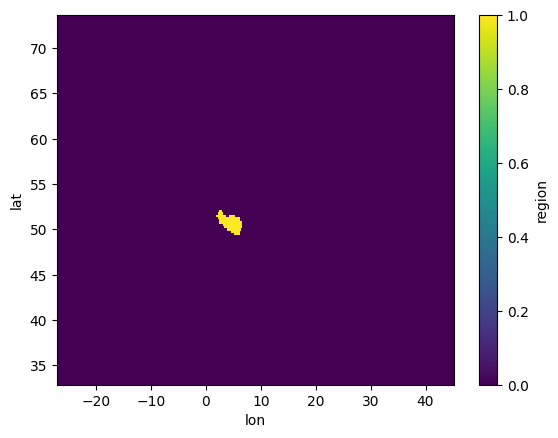

In [13]:
# plot the mask
mask_shp.plot()